## Examples

In [6]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from dataset import LinearDynamicalDataset, WHDataset
from torch.utils.data import DataLoader
from lstm_onestep import LSTModel
from matplotlib.lines import Line2D

In [7]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [8]:
def evaluate(batch_u, batch_y, model, initial_sequence, one_step):
    with torch.no_grad():
        seq_length = batch_u.shape[1]
        n_u = batch_u.shape[2]
        n_y = batch_y.shape[2]
        
        input_seq = batch_u

        start_zero = torch.zeros([1, 1, n_y])
        input_y = batch_y[:, 0:init_sequence, :]
        input_y = torch.cat((start_zero, input_y), dim=1)
        zeros = torch.zeros([1,seq_length - init_sequence - 1, n_y])
        input_y = torch.cat((input_y, zeros), dim=1)

        input_seq = torch.cat((input_seq, input_y), dim=2)

        total_loss = 0
        for i in range(init_sequence, seq_length):
            seq = input_seq[:, 0:i+1, :]
            output, hidden = model(seq)
            loss = criterion(output[0][-1][0], batch_y[0][i][0])
            total_loss += loss
            
            if i+1 == seq_length:
                break

            if one_step:
                input_seq[0][i+1][n_u] = batch_y[0][i][0]
            else:
                input_seq[0][i+1][n_u] = output[0][-1][0]

        errors = (batch_y - output).detach().numpy()[0]
        loss = criterion(output, batch_y)
        predictions = output.detach().numpy()[0]

        print("loss without initial sequence:")
        mean_loss = total_loss / (seq_length-init_sequence)
        print(mean_loss.item())
        
        return predictions, errors
    
def plot_input_output(batch_u, batch_y, predictions, errors):
    n_u = batch_u.shape[2]
    fig, ax = plt.subplots(1, 1, sharex=True)

    ax.set_title("Output")
    ax.plot(batch_y[0], c='black', label='y')
    ax.plot(predictions, c='blue', label='ŷ')
    ax.plot(errors, c='red', label='y - ŷ')
    ax.legend(prop={'size': 10})
    
    plt.show()

In [9]:
nx = 5
nu = 1
ny = 1

model_lstm = LSTModel(input_size=nu + ny, output_size=ny, hidden_dim=512, n_layers=4)
model_lstm.load_state_dict(torch.load('out/lstm_model200000', map_location=device))
model_lstm.eval()

criterion = nn.MSELoss()

In [10]:
test_ds = LinearDynamicalDataset(nx=5, nu=1, ny=1, seq_len=100)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)
init_sequence = 1
one_step = True
batch_y, batch_u = next(iter(test_dl))

In [11]:
predictions_lstm, errors_lstm = evaluate(batch_u, batch_y, model_lstm, init_sequence, one_step)

loss without initial sequence:
0.013415796682238579


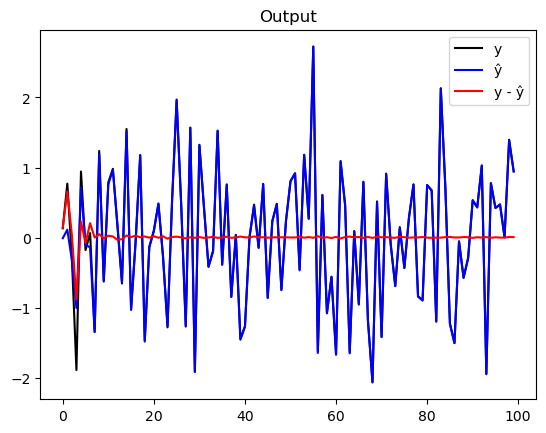

In [12]:
plot_input_output(batch_u, batch_y, predictions_lstm, errors_lstm)

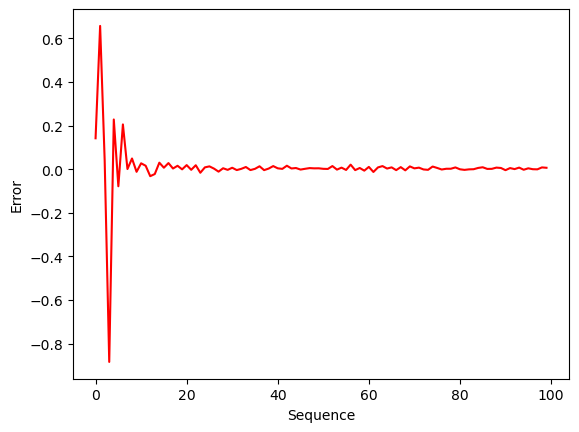

In [13]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_lstm.flatten(), label='LSTM', c='red')
plt.show()

In [14]:
test_ds = LinearDynamicalDataset(nx=5, nu=1, ny=1, seq_len=400)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

actual_out = []
errors = []
for i in range(10):
    batch_y, batch_u = next(iter(test_dl))
    predictions_lstm, errors_lstm = evaluate(batch_u, batch_y, model_lstm, init_sequence, one_step)
    actual_out.append(batch_u.flatten().tolist())
    errors.append(errors_lstm.flatten().tolist())

    
custom_lines = [Line2D([0], [0], color='black'),
                Line2D([0], [0], color='red')]
plt.xlabel('time step (-)')
for ao in actual_out:
    plt.plot(ao, c='black')
for err in errors:
    plt.plot(err, c='red')
plt.legend(custom_lines, ['y', 'y - ŷ'])
plt.show()


loss without initial sequence:
0.008115840144455433
loss without initial sequence:
9.715092892292887e-05
loss without initial sequence:
0.00045121440780349076
loss without initial sequence:
0.0007982118986546993
loss without initial sequence:
0.005340835079550743


loss without initial sequence:
0.3335772752761841


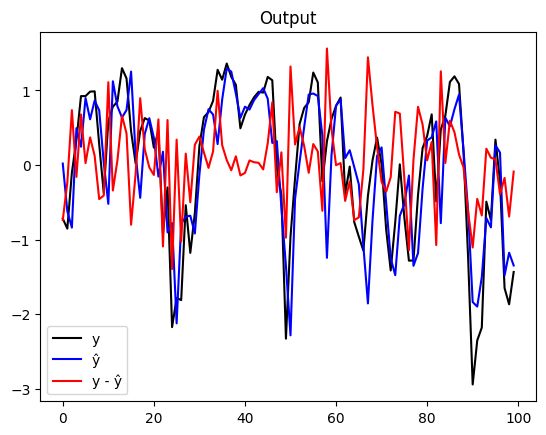

In [ ]:
model_wh = LSTModel(input_size=2, output_size=1, hidden_dim=512, n_layers=4)
model_wh.load_state_dict(torch.load('trained_models/wh_lstm_model200000', map_location=device))

test_ds = WHDataset(nx=5, nu=1, ny=1, seq_len=100)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

init_sequence = 1
one_step = True
batch_y, batch_u = next(iter(test_dl))

predictions_wh, errors_wh = evaluate(batch_u, batch_y, model_wh, init_sequence, one_step)

plot_input_output(batch_u, batch_y, predictions_wh, errors_wh)

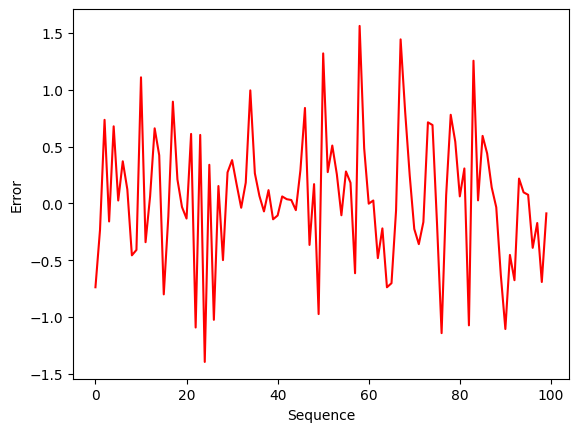

In [ ]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_wh.flatten(), c='red')
plt.show()

loss without initial sequence:
0.12714646756649017


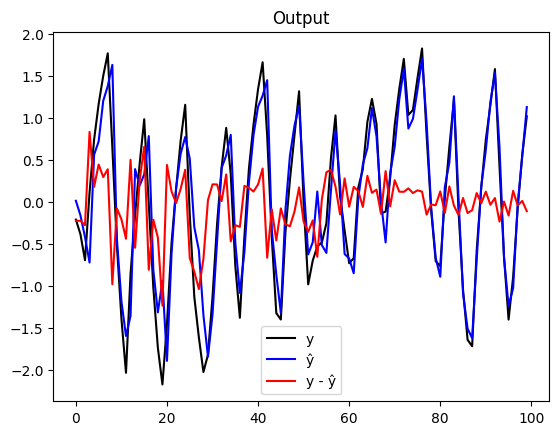

In [ ]:
model_wh = LSTModel(input_size=2, output_size=1, hidden_dim=512, n_layers=4)
model_wh.load_state_dict(torch.load('trained_models/lstm_wh_model_1000000', map_location=device))

test_ds = WHDataset(nx=5, nu=1, ny=1, seq_len=100)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

init_sequence = 1
one_step = True
batch_y, batch_u = next(iter(test_dl))

predictions_wh, errors_wh = evaluate(batch_u, batch_y, model_wh, init_sequence, one_step)

plot_input_output(batch_u, batch_y, predictions_wh, errors_wh)

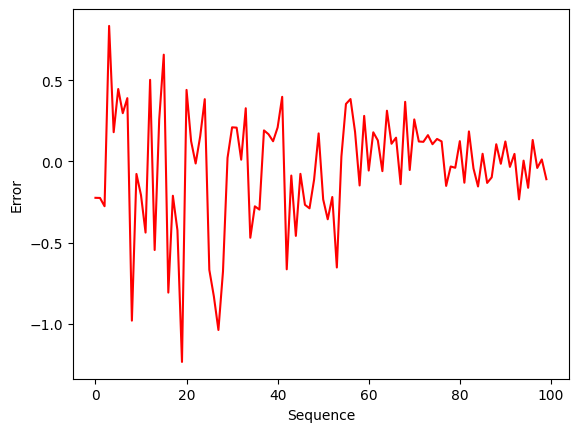

In [ ]:
plt.xlabel("Sequence")
plt.ylabel("Error")
plt.plot(errors_wh.flatten(), c='red')
plt.show()

loss without initial sequence:
0.017652230337262154
loss without initial sequence:
0.006038908381015062
loss without initial sequence:
0.1190020740032196
loss without initial sequence:
0.010401317849755287
loss without initial sequence:
0.11879167705774307
loss without initial sequence:
0.005249822977930307
loss without initial sequence:
0.14325185120105743
loss without initial sequence:
0.03292161598801613
loss without initial sequence:
0.003650349797680974
loss without initial sequence:
0.01364956796169281


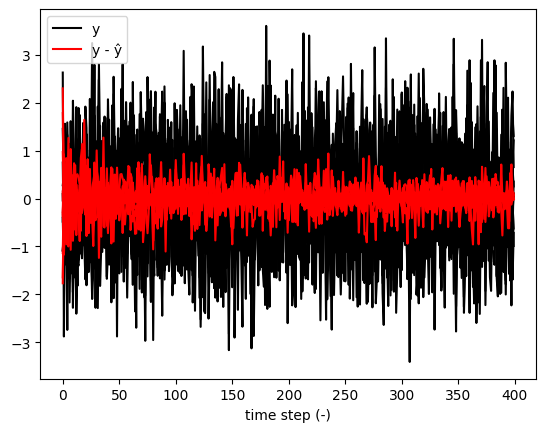

In [ ]:
test_ds = WHDataset(nx=5, nu=1, ny=1, seq_len=400)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

actual_out = []
errors = []
for i in range(10):
    batch_y, batch_u = next(iter(test_dl))
    predictions_wh, errors_wh = evaluate(batch_u, batch_y, model_wh, init_sequence, one_step)
    actual_out.append(batch_u.flatten().tolist())
    errors.append(errors_wh.flatten().tolist())

    
custom_lines = [Line2D([0], [0], color='black'),
                Line2D([0], [0], color='red')]
plt.xlabel('time step (-)')
for ao in actual_out:
    plt.plot(ao, c='black')
for err in errors:
    plt.plot(err, c='red')
plt.legend(custom_lines, ['y', 'y - ŷ'])
plt.show()    